In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import math
class QuantumCircuitSparse:
    numWires = 0
    circuit = np.array([[0]])
    eye = np.array([[1.]])
    data = np.array([0])
    sparseImplementation = False
    calculateOnFlow = False
    unitary = []
    def __init__(self, numWires, input, calculateOnFlow):
        self.numWires = numWires
        self.calculateOnFlow = calculateOnFlow
        self.circuit = sp.sparse.csr_matrix(sp.sparse.identity(2**numWires,dtype='complex'))
        self.data = input   
    def TensorProduct(self, matrices):
        product = matrices[0]
        for matrix in matrices[1:]:
            product = sp.sparse.kron(product,matrix,format='csr')
        return product 
    
    def xyModN(self, x, N, size):
        U = np.zeros((size, size))
        for i in range(U.shape[0]):
            newNum = (i * x) % N
            if newNum >= N:
                U[i,i] = 1
                continue
            U[newNum, i] = 1
        return U
    def AddGate(self,gate):
        if gate[0] == 'H':
            self.AddHadarmand(int(gate[1]))
        elif gate[0] == 'U':
            self.AddCAboveU(int(gate[1]), int(gate[2]), self.unitary)
        elif gate[0] == 'P':
            self.AddPhase(int(gate[1]),np.double(gate[2]))
        elif gate[0] == 'CNOT':
            self.AddCNot(int(gate[1]), int(gate[2]))
        elif gate[0] == 'CPHASE':
            self.AddCPhase(int(gate[1]), int(gate[2]), np.double(gate[3]))
        elif gate[0] == 'SWAP':
            self.AddSwap(int(gate[1]), int(gate[2]))
        elif gate[0] == 'INVQFT':
            self.AddInvQFT(int(gate[1]), int(gate[2]))
        elif gate[0] == 'QFT':
            self.AddInvQFT(int(gate[1]), int(gate[2]))
        elif gate[0] == 'CFUNC':
            u = self.xyModN(int(gate[-2]), int(gate[-1]),2**int(gate[3]))
            print(u)
            self.AddCAboveU(int(gate[1]), int(gate[2]),u)
        elif gate[0] == 'FUNC':
            u = self.xyModN(int(gate[-2]), int(gate[-1]),2**int(gate[2]))
            print(u)
            self.AddU(int(gate[1]),u)

    def AddU(self, wire, matrix):
        gateEnd = wire + int(np.log2(matrix.shape[0])) - 1
        matrices = []
        for i in range(wire):
            matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
        matrices.append(matrix)
        for j in range(gateEnd+1, self.numWires, 1):
            matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
        unitary = self.TensorProduct(matrices)
        if self.calculateOnFlow:
            self.data = unitary @ self.data
        else:
            self.circuit = unitary @ self.circuit
        return unitary
    def AddHadarmand(self, wire):
        H = sp.sparse.csr_matrix([[0.5**0.5,0.5**0.5],[0.5**0.5,-0.5**0.5]])
        matrices = []
        for i in range(self.numWires):
            if i != wire:
                matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
            else:
                matrices.append(H)
        unitaryH = self.TensorProduct(matrices)
        if self.calculateOnFlow:
            self.data = unitaryH @ self.data
        else:
            self.circuit = unitaryH @ self.circuit
        return unitaryH

    def AddPhase(self, wire, theta):
        P = sp.sparse.csr_matrix([[1.,0],[0,np.exp(1.j * theta)]])
        matrices = []
        for i in range(self.numWires):
            if i != wire:
                matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
            else:
                matrices.append(P)
        unitaryP = self.TensorProduct(matrices)
        if self.calculateOnFlow:
            self.data = unitaryP @ self.data
        else:
            self.circuit = unitaryP @ self.circuit
        return unitaryP
        
    def AddCNot(self, ctrlWire, otherWire):
        matrices = []
        for i in range(min(ctrlWire, otherWire)):
            matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
        identityPart = []
        notPart = []
        for j in range(min(ctrlWire, otherWire), max(ctrlWire, otherWire) + 1, 1):
            if j == ctrlWire:
                identityPart.append(sp.sparse.csr_matrix([[1.,0],[0,0]]))
                notPart.append(sp.sparse.csr_matrix([[0,0],[0,1.]]))
                continue
            if j == otherWire:
                identityPart.append(sp.sparse.identity(2,dtype='complex'))
                notPart.append(sp.sparse.csr_matrix([[0,1.],[1.,0]]))
                continue
            identityPart.append(sp.sparse.identity(2,dtype='complex'))
            notPart.append(sp.sparse.identity(2,dtype='complex'))
        cNot = self.TensorProduct(identityPart) + self.TensorProduct(notPart)
        matrices.append(cNot)
        for k in range(max(ctrlWire, otherWire) + 1, self.numWires, 1):
            matrices.append(sp.sparse.identity(2,dtype='complex'))
        unitaryCNot = self.TensorProduct(matrices)
        if self.calculateOnFlow:
            self.data = unitaryCNot @ self.data
        else:
            self.circuit = unitaryCNot @ self.circuit
        return unitaryCNot

    def AddCAboveU(self, ctrlWire, otherWireStart, matrix):
        matrix = np.array(matrix)
        otherWireEnd = otherWireStart + int(np.log2(matrix.shape[0])) - 1
        matrices = []
        for i in range(ctrlWire):
            matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
        #from top to ctrl
        

        identityPart = [sp.sparse.csr_matrix([[1.,0],[0,0]])]
        uPart = [sp.sparse.csr_matrix([[0,0],[0,1.]])]
        #ctrl
        for j in range(ctrlWire+1, otherWireStart, 1):
            identityPart.append(sp.sparse.identity(2,dtype='complex'))
            uPart.append(sp.sparse.identity(2,dtype='complex'))
        #from ctrl to other
        identityPart.append(sp.sparse.identity(matrix.shape[0],dtype='complex'))
        uPart.append(sp.sparse.csr_matrix(matrix, dtype='complex'))
        #other
        
        cU = self.TensorProduct(identityPart) + self.TensorProduct(uPart)
        matrices.append(cU)
        #the whole Unitary piece
        for k in range(otherWireEnd + 1, self.numWires, 1):
            matrices.append(sp.sparse.identity(2,dtype='complex'))

        #from other to end
        unitary = self.TensorProduct(matrices)
        if self.calculateOnFlow:
            self.data = unitary @ self.data
        else:
            self.circuit = unitary @ self.circuit
        return unitary


    def AddCRz(self, ctrlWire, otherWire, theta):
        theta = theta / 2.
        if self.sparseImplementation:
            matrix = sp.sparse.scr_matrix([[1,0,0,0],[0,1,0,0],[0,0,np.exp(-1.j*theta/2.), 0], [0,0,0,np.exp(1.j*theta/2.)]])
            
    def AddNot(self, wire):
        self.AddHadarmand(wire)
        self.AddPhase(wire, np.pi)
        self.AddHadarmand(wire)
    
    def AddRz(self, wire, theta):
        theta = theta / 2.
        self.AddPhase(wire, theta)
        self.AddNot(wire)
        self.AddPhase(wire, -theta)
        self.AddNot(wire)

    def AddSwap(self,wire1, wire2):
        self.AddCNot(wire1, wire2)
        self.AddCNot(wire2, wire1)
        self.AddCNot(wire1, wire2)
    
    def AddCPhase(self, ctrlWire, otherWire, theta):
        matrices = []
        for i in range(min(ctrlWire, otherWire)):
            matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
        identityPart = []
        phasePart = []
        for j in range(min(ctrlWire, otherWire), max(ctrlWire, otherWire) + 1, 1):
            if j == ctrlWire:
                identityPart.append(sp.sparse.csr_matrix([[1.,0],[0,0]]))
                phasePart.append(sp.sparse.csr_matrix([[0,0],[0,1]]))
                continue
            if j == otherWire:
                identityPart.append(sp.sparse.identity(2,dtype='complex'))
                phasePart.append(sp.sparse.csr_matrix([[1.,0],[0,np.exp(1.j * theta)]]))
                continue
            identityPart.append(sp.sparse.identity(2,dtype='complex'))
            phasePart.append(sp.sparse.identity(2,dtype='complex'))
        cPhase = self.TensorProduct(identityPart) + self.TensorProduct(phasePart)
        matrices.append(cPhase)
        for k in range(max(ctrlWire, otherWire) + 1, self.numWires, 1):
            matrices.append(sp.sparse.identity(2,dtype='complex'))
        unitaryCPhase = self.TensorProduct(matrices)
        if self.calculateOnFlow:
            self.data = unitaryCPhase @ self.data
        else:
            self.circuit = unitaryCPhase @ self.circuit
        return unitaryCPhase
    def AddQFT(self, startWire, endWire):
        #H0
        #P10 H1
        #P20 P21 H2
        self.AddHadarmand(startWire)
        for controlWire in range(startWire+1,endWire + 1,1):
            for otherWire in range(startWire, controlWire, 1):
                theta = np.pi / (2**(controlWire - otherWire))
                self.AddCPhase(controlWire, otherWire, theta)
            self.AddHadarmand(controlWire)
        #0 1 2 3 4 5
        #0 1 2
        for i in range((self.numWires-1) // 2):
            self.AddSwap(startWire + i, endWire-i)

    def AddInvQFT(self, startWire, endWire):
        for i in range((self.numWires-1) // 2):
            self.AddSwap(startWire + i, endWire-i)
        
        for controlWire in range(endWire,startWire,-1):
            self.AddHadarmand(controlWire)
            for otherWire in range(controlWire-1, startWire-1, -1):
                theta = -np.pi / (2**(controlWire - otherWire))
                self.AddCPhase(controlWire, otherWire, theta)
        self.AddHadarmand(startWire)

    def Calculate(self, input):
        if self.calculateOnFlow:
            result = self.data
        else:
            result = self.circuit @ input
        probability = (np.abs(result)) ** 2
        levels = np.cumsum(probability)
        f = np.random.ranf()
        collapsedMeasurement = np.zeros(2**self.numWires)
        for i in range(len(levels)):
            if f <= levels[i]:
                collapsedMeasurement[i] = 1
                break
        return {'stateVectors':result, 'probabilities':probability, 'measurement':collapsedMeasurement}
    


#deprecated        
class QuantumCircuit:
    numWires = 0
    circuit = np.array([[0]])
    eye = np.array([[1.]])
    data = np.array([0])
    sparseImplementation = False
    calculateOnFlow = False
    def __init__(self, numWires, input, calculateOnFlow, sparseImplementation):
        self.numWires = numWires
        self.calculateOnFlow = calculateOnFlow
        self.sparseImplementation = sparseImplementation
        if sparseImplementation:
            self.circuit = sp.sparse.csr_matrix(sp.sparse.identity(2**numWires,dtype='complex'))
            self.data = input        
            return
        else:
            self.circuit = np.eye(2**self.numWires)
            self.data = input
            return
    def TensorProduct(self, matrices):
        if self.sparseImplementation:
            product = matrices[0]
            for matrix in matrices[1:]:
                product = sp.sparse.kron(product,matrix,format='csr')
            return product 
        else:
            product = matrices[0]
            for matrix in matrices[1:]:
                product = np.kron(product, matrix)
            return product 
    def AddGate(self,gate):
        if gate[0] == 'H':
            self.AddHadarmand(int(gate[1]))
        elif gate[0] == 'P':
            self.AddPhase(int(gate[1]),np.double(gate[2]))
        elif gate[0] == 'CNOT':
            self.AddCNot(int(gate[1]), int(gate[2]))
    def AddHadarmand(self, wire):
        if self.sparseImplementation:
            H = sp.sparse.csr_matrix([[0.5**0.5,0.5**0.5],[0.5**0.5,-0.5**0.5]])
            matrices = []
            for i in range(self.numWires):
                if i != wire:
                    matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
                else:
                    matrices.append(H)
        else:
            H = 0.5**0.5 * np.array([[1.,1],[1,-1]])
            matrices = []
            for i in range(self.numWires):
                if i != wire:
                    matrices.append(np.eye(2))
                else:
                    matrices.append(H)
        unitaryH = self.TensorProduct(matrices)
        if self.calculateOnFlow:
            self.data = unitaryH @ self.data
        else:
            self.circuit = unitaryH @ self.circuit
        return unitaryH

    def AddPhase(self, wire, theta):
        if self.sparseImplementation:
            P = sp.sparse.csr_matrix([[1.,0],[0,np.exp(1.j * theta)]])
            matrices = []
            for i in range(self.numWires):
                if i != wire:
                    matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
                else:
                    matrices.append(P)
        else:
            P = np.array([[1.,0],[0,np.exp(1.j * theta)]])
            matrices = []
            for i in range(self.numWires):
                if i != wire:
                    matrices.append(np.eye(2))
                else:
                    matrices.append(P)
        unitaryP = self.TensorProduct(matrices)
        if self.calculateOnFlow:
            self.data = unitaryP @ self.data
        else:
            self.circuit = unitaryP @ self.circuit
        return unitaryP
    
    def AddCNot(self, ctrlWire, otherWire):
        if self.sparseImplementation:
            matrices = []
            for i in range(min(ctrlWire, otherWire)):
                matrices.append(sp.sparse.csr_matrix(sp.sparse.identity(2,dtype='complex')))
            identityPart = []
            notPart = []
            for j in range(min(ctrlWire, otherWire), max(ctrlWire, otherWire) + 1, 1):
                if j == ctrlWire:
                    identityPart.append(sp.sparse.csr_matrix([[1.,0],[0,0]]))
                    notPart.append(sp.sparse.csr_matrix([[0,0],[0,1.]]))
                    continue
                if j == otherWire:
                    identityPart.append(sp.sparse.identity(2,dtype='complex'))
                    notPart.append(sp.sparse.csr_matrix([[0,1.],[1.,0]]))
                    continue
                identityPart.append(sp.sparse.identity(2,dtype='complex'))
                notPart.append(sp.sparse.identity(2,dtype='complex'))
            cNot = self.TensorProduct(identityPart) + self.TensorProduct(notPart)
            matrices.append(cNot)
            for k in range(max(ctrlWire, otherWire) + 1, self.numWires, 1):
                matrices.append(sp.sparse.identity(2,dtype='complex'))
        else:
            matrices = []
            for i in range(min(ctrlWire, otherWire)):
                matrices.append(np.eye(2))
            identityPart = []
            notPart = []
            for j in range(min(ctrlWire, otherWire), max(ctrlWire, otherWire) + 1, 1):
                if j == ctrlWire:
                    identityPart.append(np.array([[1.,0],[0,0]]))
                    notPart.append(np.array([[0,0],[0,1.]]))
                    continue
                if j == otherWire:
                    identityPart.append(np.eye(2))
                    notPart.append(np.array([[0,1.],[1,0]]))
                    continue
                identityPart.append(np.eye(2))
                notPart.append(np.eye(2))
            cNot = self.TensorProduct(identityPart) + self.TensorProduct(notPart)
            matrices.append(cNot)
            for k in range(max(ctrlWire, otherWire) + 1, self.numWires, 1):
                matrices.append(np.eye(2))
        unitaryCNot = self.TensorProduct(matrices)
        if self.calculateOnFlow:
            self.data = unitaryCNot @ self.data
        else:
            self.circuit = unitaryCNot @ self.circuit
        return unitaryCNot
    def AddCRz(self, ctrlWire, otherWire, theta):
        theta = theta / 2.
        if self.sparseImplementation:
            matrix = sp.sparse.scr_matrix([[1,0,0,0],[0,1,0,0],[0,0,np.exp(-1.j*theta/2.), 0], [0,0,0,np.exp(1.j*theta/2.)]])
            
    def AddNot(self, wire):
        self.AddHadarmand(wire)
        self.AddPhase(wire, np.pi)
        self.AddHadarmand(wire)
    
    def AddRz(self, wire, theta):
        theta = theta / 2.
        self.AddPhase(wire, theta)
        self.AddNot(wire)
        self.AddPhase(wire, -theta)
        self.AddNot(wire)

    def AddSwap(self,wire1, wire2):
        self.AddCNot(wire1, wire2)
        self.AddCNot(wire2, wire1)
        self.AddCNot(wire1, wire2)
    
    def AddCPhase(self, ctrlWire, otherWire, theta):
        CPhaseNeighbor = sp.sparse.scr_matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,np.exp(1.j*theta)]])

    def Calculate(self, input):
        if self.calculateOnFlow:
            result = self.data
        else:
            result = self.circuit @ input
        probability = (np.abs(result)) ** 2
        levels = np.cumsum(probability)
        f = np.random.ranf()
        collapsedMeasurement = np.zeros(2**self.numWires)
        for i in range(len(levels)):
            if f <= levels[i]:
                collapsedMeasurement[i] = 1
                break
        return {'stateVectors':result, 'probabilities':probability, 'measurement':collapsedMeasurement}


In [2]:
def PrettyPrintBinary(myState):
    for density, state in myState:
        prettyStateStr = str(density) + '  |' + state + '>'
        print(prettyStateStr + '   ')
        
def PrettyPrintInteger(myState):
    for density, stateAsBinary in myState:
        stateAsInt = 0
        for exponent, bit in enumerate(stateAsBinary):
            stateAsInt += int(bit) * 2 ** (len(stateAsBinary)-1-exponent)
        prettyStateStr = str(density) + '  |' + str(stateAsInt) + '>'
        print(prettyStateStr + '   ')

def StateToVec(myState):
    vector = np.zeros(2**len(myState[0][1]), dtype=np.cdouble)
    for density, stateAsBinary in myState:
        stateAsInt = 0
        for exponent, bit in enumerate(stateAsBinary):
            stateAsInt += int(bit) * 2 ** (len(stateAsBinary)-1-exponent)
        vector[stateAsInt] = density
    return np.array(vector)

def VecToState(myStateAsVector):
    myState = []
    for i, density in enumerate(myStateAsVector):
        if density == 0 + 0j:
            continue
        state = str(bin(i))[2:].zfill(int(math.log2(len(myStateAsVector))))
        myState.append((density, state))
    return myState
def ReadState(fileName):
    myState_lines=open(fileName).readlines()
    myState=np.zeros(len(myState_lines), dtype=np.cdouble)
    for i in range(len(myState_lines)):
        real, complex = myState_lines[i].split(' ')
        real = float(real)
        complex = float(complex)
        myState[i] = real + complex * 1.j
    return myState

def ReadInput(fileName):
    myInput_lines=open(fileName).readlines()
    gates=[]
    numberOfWires=int(myInput_lines[0])
    input = np.zeros(2**numberOfWires)
    input[0] = 1
    circuitStartIndex = 1
    circuitEndIndex = len(myInput_lines)
    if myInput_lines[1][:9] =='INITSTATE':
        instantiate, mode, value = myInput_lines[1].split(' ')
        circuitStartIndex = 2
        if mode=='BASIS':
            input = StateToVec([(1,value.strip()[1:-1])])
        if mode == 'FILE':
            input = ReadState(value.strip())
    ifMeasure = False
    if myInput_lines[-1][:7] =='MEASURE':
        circuitEndIndex = len(myInput_lines) - 1
        ifMeasure = True
    for line in myInput_lines[circuitStartIndex:circuitEndIndex]:
        gates.append(line.split())
    return (numberOfWires,gates, input, ifMeasure)

def ReadAndRun(fileName):
    numberOfWires,gates, input, ifMeasure = ReadInput(fileName)
    circuit = QuantumCircuitSparse(numberOfWires, input, True)
    for gate in gates:
        circuit.AddGate(gate)
    result = circuit.Calculate(input)
    if ifMeasure:
        return result['probabilities']
    else:
        return result['stateVectors']

<BarContainer object of 32 artists>

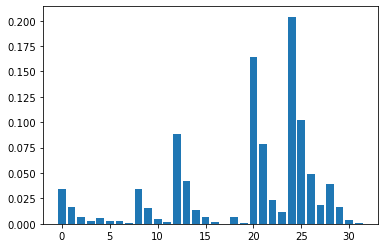

In [3]:
import matplotlib.pyplot as plt

probabilities = ReadAndRun('measure.circuit')
x = [i for i in range(2**5)]
plt.bar(x, probabilities)

In [51]:
import time
numWires, gates, input, ifmeasure = ReadInput('swap.circuit')
state = '000111'
myState = [(1, state)]
myStateVec = StateToVec(myState)
circuit = QuantumCircuitSparse(numWires, myStateVec, True)
for gate in gates:
    circuit.AddGate(gate)
result = circuit.Calculate(myStateVec)
print(VecToState(result['stateVectors']))

#Rz = PXPX
#Not = HP(pi)H

[((1+0j), '001110')]


In [30]:
PrettyPrintBinary(VecToState(ReadAndRun('cphase.circuit')))

(0.7071067811865476+0j)  |000000000>   
(0.7071067811865476+0j)  |100000000>   


In [7]:
myState = [(1, '0')]
myStateVec = StateToVec(myState)
theta = 1.0
RZGateCircuit = QuantumCircuit(1, myStateVec, True, True)
RZGateCircuit.AddPhase(0, theta)
RZGateCircuit.AddNot(0)
RZGateCircuit.AddPhase(0, -theta)
RZGateCircuit.AddNot(0)
result = RZGateCircuit.Calculate(myStateVec)
print(result)
np.angle(result['stateVectors'][0])

{'stateVectors': array([5.40302306e-01-0.84147098j, 5.55111512e-17+0.j        ]), 'probabilities': array([1.00000000e+00, 3.08148791e-33]), 'measurement': array([1., 0.])}


-1.0

### Time complexity check

Text(0.5, 0, 'qubits')

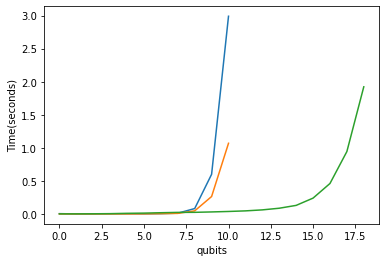

In [14]:
import time
import matplotlib.pyplot as plt
baseTime = []
calculateOnFlowTime = []
sparseImplementationTime = []

for numWires in range(1, 20, 1):
    myStateVec = np.zeros(2**numWires)
    if numWires <= 11:
        t0 = time.time()
        circuit = QuantumCircuit(numWires, myStateVec, False, False)
        for wire in range(numWires):
            circuit.AddHadarmand(wire)
        circuit.Calculate(myStateVec)
        baseTime.append(time.time() - t0)

    if numWires <= 11:
        t0 = time.time()
        circuit = QuantumCircuit(numWires, myStateVec, True, False)
        for wire in range(numWires):
            circuit.AddHadarmand(wire)
        circuit.Calculate(myStateVec)
        calculateOnFlowTime.append(time.time() - t0)

    t0 = time.time()
    circuit = QuantumCircuit(numWires, myStateVec, True, True)
    for wire in range(numWires):
        circuit.AddHadarmand(wire)
    circuit.Calculate(myStateVec)
    sparseImplementationTime.append(time.time() - t0)
plt.plot(baseTime)
plt.plot(calculateOnFlowTime)
plt.plot(sparseImplementationTime)
plt.ylabel('Time(seconds)')
plt.xlabel('qubits')

## Phase Estimate

### test phase finding

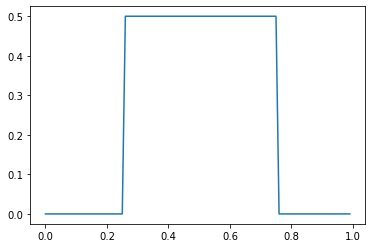

In [470]:
import matplotlib.pyplot as plt
myState = [(1, '01')]
myStateVec = StateToVec(myState)
thetaList = []
phiList = []
for i in range(100):
    circuit = QuantumCircuitSparse(2, myStateVec, True)
    circuit.AddHadarmand(0)
    phi = i * np.pi * 2 / 100.0
    circuit.AddCPhase(0,1,phi)
    circuit.AddHadarmand(0)
    probs = circuit.Calculate(myStateVec)['probabilities']
    maxInd = np.argmax(probs)
    probs = np.zeros_like(probs)
    probs[maxInd] = 1
    state = VecToState(probs)
    binTheta = state[0][1][:-1]
    floatTheta = 0.0
    for i in range(len(binTheta)):
        floatTheta += int(binTheta[i]) * 2**(-(i+1))
    thetaList.append(floatTheta)
    phiList.append(phi/ (np.pi * 2.0))
plt.plot(phiList, thetaList)


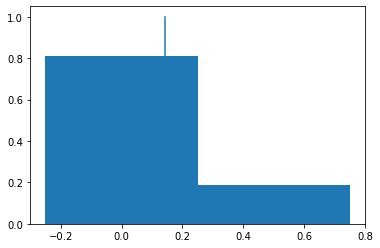

In [471]:
#0.1432394487827058
import matplotlib.pyplot as plt
myState = [(1, '01')]
myStateVec = StateToVec(myState)
circuit = QuantumCircuitSparse(2, myStateVec, True)
circuit.AddHadarmand(0)
phi = 0.1432394487827058 * 2 * np.pi
circuit.AddCPhase(0,1,phi)
circuit.AddHadarmand(0)
probsVec = circuit.Calculate(myStateVec)['probabilities']
probsStates = VecToState(probsVec)
probTheta = []
for state in probsStates:
    probTheta.append(state[0])
states = np.array(range(2))
states = states/2
plt.bar(states, probTheta, width = 0.5)
plt.plot([0.1432, 0.1432], [0,1])


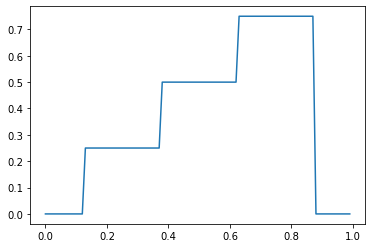

In [472]:
myState = [(1, '001')]
myStateVec = StateToVec(myState)
thetaList = []
phiList = []
for i in range(100):
    circuit = QuantumCircuitSparse(3, myStateVec, True)
    circuit.AddHadarmand(0)
    circuit.AddHadarmand(1)
    phi = i * np.pi * 2 / 100.0
    circuit.AddCPhase(1,2,phi)
    circuit.AddCPhase(0,2,phi)
    circuit.AddCPhase(0,2,phi)
    circuit.AddHadarmand(0)
    circuit.AddCPhase(0,1, -np.pi / 2.0)
    circuit.AddHadarmand(1)
    circuit.AddSwap(0,1)
    probs = circuit.Calculate(myStateVec)['probabilities']
    maxInd = np.argmax(probs)
    probs = np.zeros_like(probs)
    probs[maxInd] = 1
    state = VecToState(probs)
    binTheta = state[0][1][:-1]
    floatTheta = 0.0
    for i in range(len(binTheta)):
        floatTheta += int(binTheta[i]) * 2**(-(i+1))
    thetaList.append(floatTheta)
    phiList.append(phi/ (np.pi * 2.0))
plt.plot(phiList, thetaList)

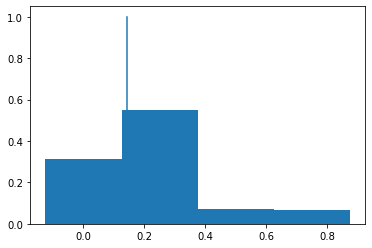

In [473]:
#0.1432394487827058
import matplotlib.pyplot as plt
myState = [(1, '001')]
myStateVec = StateToVec(myState)
circuit = QuantumCircuitSparse(3, myStateVec, True)
circuit.AddHadarmand(0)
circuit.AddHadarmand(1)
phi = 0.1432394487827058 * 2 * np.pi
circuit.AddCPhase(1,2,phi)
circuit.AddCPhase(0,2,phi)
circuit.AddCPhase(0,2,phi)
circuit.AddHadarmand(0)
circuit.AddCPhase(0,1, -np.pi / 2.0)
circuit.AddHadarmand(1)
circuit.AddSwap(0,1)
probsVec = circuit.Calculate(myStateVec)['probabilities']
probsStates = VecToState(probsVec)
probTheta = []
for state in probsStates:
    probTheta.append(state[0])
states = np.array(range(4))
states = states / 4
plt.bar(states, probTheta, width=0.25)
plt.plot([0.1432, 0.1432], [0,1])

#### Frourier Transform

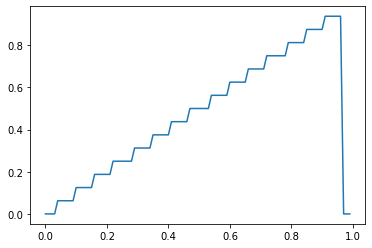

In [9]:
myState = [(1, '00001')]
myStateVec = StateToVec(myState)
thetaList = []
phiList = []
numPrecisionWires = 4
for i in range(100):
    circuit = QuantumCircuitSparse(numPrecisionWires+1, myStateVec, True)
    for h in range(numPrecisionWires):
        circuit.AddHadarmand(h)
    phi = i * np.pi * 2 / 100.0
    for ctrl in range(numPrecisionWires):
        for output in range(2 ** ctrl):
            circuit.AddCPhase(numPrecisionWires-1-ctrl,numPrecisionWires,phi)
    circuit.AddInvQFT(0,numPrecisionWires-1)
    probs = circuit.Calculate(myStateVec)['probabilities']
    maxInd = np.argmax(probs)
    probs = np.zeros_like(probs)
    probs[maxInd] = 1
    state = VecToState(probs)
    binTheta = state[0][1][:-1]
    floatTheta = 0.0
    for i in range(len(binTheta)):
        floatTheta += int(binTheta[i]) * 2**(-(i+1))
    thetaList.append(floatTheta)
    phiList.append(phi/ (np.pi * 2.0))
plt.plot(phiList, thetaList)

64
64


C:\Users\Yubisoft\anaconda3\envs\scientific\lib\site-packages\matplotlib\transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


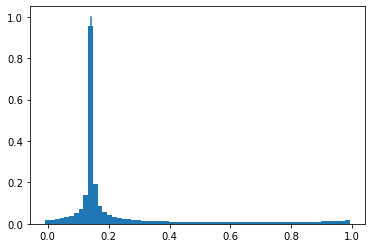

In [474]:
probsVec = np.abs(ReadAndRun('6wirePhase.circuit'))
probsStates = VecToState(probsVec)
#get rid of duplicate states: the last bit can be 0 or 1, with same probability
for i in range(len(probsStates)):
    probsStates[i] = (probsStates[i][0], probsStates[i][1][:-1])
probsStates = VecToState(StateToVec(probsStates))

probTheta = []
for state in probsStates:
    probTheta.append(state[0])
states = np.array(range(2**6))
states = states / 2.0**6
print(len(states))
print(len(probTheta))
plt.bar(states, probTheta, width=1.0 / 2**6)
plt.plot([0.143,0.143],[0,1])

# Phase measurement wrapper func

demostrate QFT

In [83]:
import numpy.linalg as la
myState = [(1, '01')]
myStateVec = StateToVec(myState)
PrettyPrintBinary(myState)
testCircuit2 = QuantumCircuitSparse(2, myStateVec, True)
testCircuit2.AddInvQFT(0,1)
PrettyPrintBinary(VecToState(testCircuit2.Calculate(myStateVec)['stateVectors']))

1  |01>   
(0.5000000000000001+0j)  |00>   
(-0.5000000000000001+0j)  |01>   
(0.5000000000000001+0j)  |10>   
(-0.5000000000000001+0j)  |11>   


In [99]:
myStateVec = ReadState('myInputState.txt')
testCircuit = QuantumCircuitSparse(5, myStateVec, True)
testCircuit.AddQFT(0,4)
PrettyPrintBinary(VecToState(testCircuit.Calculate(myStateVec)['stateVectors']))

(-0.040280172843978994-0.2209221858097979j)  |00000>   
(0.14110242611258716+0.16650808261166428j)  |00001>   
(0.18477309891527147+0.06390445657675543j)  |00010>   
(0.00028527132556335766-0.022246985487152482j)  |00011>   
(0.1566593732644432-0.08463583856503612j)  |00100>   
(0.21186219852653598-0.13549377193560455j)  |00101>   
(0.02443656354617315+0.007291647371941313j)  |00110>   
(0.12275573414814138-0.20487331415853335j)  |00111>   
(0.21663304951566456+0.020112971083311827j)  |01000>   
(0.10723693789509368+0.0013057823514517307j)  |01001>   
(-0.23523338562565801-0.0009765323146217371j)  |01010>   
(-0.07704606573094865-0.1673917459145034j)  |01011>   
(-0.001440569053744907+0.1086347996514284j)  |01100>   
(-0.045213012026622604-0.11330274327482462j)  |01101>   
(-0.19912455571863333-0.11323570695048289j)  |01110>   
(-0.1594660009530418+0.14668225282002412j)  |01111>   
(-0.03374953559586267+0.0794227539691016j)  |10000>   
(0.027995996982162083-0.0006560027147068798j)  |10

### demonstrate phase estimation with unitary gate

(0.7648421872844888+0.6442176872376911j)  |0>   
(-1.5643707157699578e-16+1.3392009728585283e-17j)  |1>   
32
32


<BarContainer object of 32 artists>

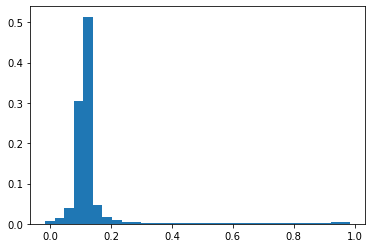

In [499]:
myState = [(1, '0')]
myStateVec = StateToVec(myState)
unitary = QuantumCircuitSparse(1, myStateVec, False)
unitary.AddNot(0)
unitary.AddPhase(0,0.7)
unitary.AddNot(0)
unitary.AddPhase(0,0.7)
u = (unitary.circuit).todense()
PrettyPrintBinary(VecToState(unitary.Calculate(myStateVec)['stateVectors']))

myState2 = [(1, '100000')]
myStateVec2 = StateToVec(myState)
numberOfWires,gates, input, ifMeasure = ReadInput('customU.circuit')
circuit = QuantumCircuitSparse(numberOfWires, input, True)
circuit.unitary = u
for gate in gates:
    circuit.AddGate(gate)
result = circuit.Calculate(input)
probsVec = result['probabilities']
probsStates = VecToState(probsVec)
#get rid of duplicate states: the last bit can be 0 or 1, with same probability
for i in range(len(probsStates)):
    probsStates[i] = (probsStates[i][0], probsStates[i][1][:-1])
probsStates = VecToState(StateToVec(probsStates))

probTheta = []
for state in probsStates:
    probTheta.append(state[0])
states = np.array(range(2**5))
states = states / 2.0**5
print(len(states))
print(len(probTheta))
plt.bar(states, probTheta, width=1.0 / 2**5)



#### Shor

In [647]:
import sympy
def Shor(N):
    if sympy.isprime(N):
        print('prime')
        return [-1,-1]
    if N % 2 == 0:
        print('even')
        return [-1,-1]
    for a in range(2, int(np.log2(N))):
        tocheck = N ** (1.0/a)
        if tocheck - int(tocheck) == 0:
            print('N = x^a', a)
            return [-1,-1]
    x = np.random.randint(3, int(N**0.5) + 1)
    while sympy.gcd(x, N) != 1:
        x = np.random.randint(1, int(N**0.5) + 1)
    print('gcd', x)
    r = 1
    while (x**r) % N != 1:
        r = r + 1

    if r % 2 != 0:
        print('odd r')
        return [-1,-1]
    print(x,r)
    result = [int(sympy.gcd(x**(r//2)-1, N)), int(sympy.gcd(N, x**(r//2)+1))]
    if result[0] == 1 or result[1] == 1:
        return [-1,-1]
    return result

In [689]:
a = Shor(33)
print(a)

gcd 5
5 10
[11, 3]


In [456]:
def BuildU(x, N):
    nBits = int(np.ceil(np.log2(N)))
    U = np.zeros((N, N))
    for i in range(U.shape[0]):
        newNum = (i * x) % N
        if newNum >= N:
            U[i,i] = 1
            continue
        U[newNum, i] = 1
    return U

In [882]:
from fractions import Fraction
def Shor2(N):
    if sympy.isprime(N):
        print('prime')
        return [-1,-1]
    if N % 2 == 0:
        print('even')
        return [-1,-1]
    for a in range(2, int(np.log2(N))):
        tocheck = N ** (1.0/a)
        if tocheck - int(tocheck) == 0:
            print('N = x^a', a)
            return [-1,-1]
    x = np.random.randint(3, int(N**0.5) + 1)
    x=2
    while sympy.gcd(x, N) != 1:
        x = np.random.randint(1, int(N**0.5) + 1)
    print(x)
    u =BuildU(x, N)
    e = np.unique(np.log(la.eigvals(u)) / (np.pi * 2) * 1.j)
    r = 1
    while (x**r) % N != 1:
        r = r + 1

    if r % 2 != 0:
        print('odd r')
        return [-1,-1]
    result = [int(sympy.gcd(x**(r//2)-1, N)), int(sympy.gcd(N, x**(r//2)+1))]
    if result[0] == 1 or result[1] == 1:
        return [-1,-1]
    return r, np.array(e,dtype=np.double)

In [898]:
r,e=Shor2(63)
e = list(np.abs(e))
epos = []
for i in range(len(e)):
    if e[i] > 0.0001:
        epos.append(e[i])
print(r,epos)

period = Fraction(min(epos)).limit_denominator(20).denominator

2
6 [0.5, 0.5, 0.33333333333333337, 0.3333333333333333, 0.16666666666666657, 0.16666666666666657, 0.3333333333333333, 0.33333333333333337]


C:\Users\Yubisoft\AppData\Local\Temp/ipykernel_12400/3321343259.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  return r, np.array(e,dtype=np.double)


In [903]:
myState = [(1,'00')]
myStateVec = StateToVec(myState)
c = QuantumCircuitSparse(2, myStateVec, False)
c.AddNot(0)
c.AddNot(1)
gate = c.circuit.todense()
myState = [(1,'10010')]
myStateVec = StateToVec(myState)
test = QuantumCircuitSparse(5, myStateVec, True)
test.AddCAboveU(0, 2, gate)
result = test.Calculate(myStateVec)
PrettyPrintBinary(VecToState(result['stateVectors']))

(3.7493994566546454e-33+6.123233995736769e-17j)  |10000>   
(-3.7493994566546454e-33+0j)  |10010>   
(1.0000000000000002-1.2246467991473537e-16j)  |10100>   
6.123233995736767e-17j  |10110>   


In [13]:
result = ReadAndRun('cfunc.circuit')
PrettyPrintBinary(VecToState(result))

[[1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
(1+0j)  |11010>   
